In [1]:
# Please execute this cell (shift+<Return>) before starting the workbook
# this should print out "Your notebook is ready to go"
from IPython.display import HTML, SVG, display
import os
import sys
from IPython.display import HTML, SVG, display
sys.path.append(os.path.abspath('genealogy_workshop'))

import genealogical_analysis_workshop

workbook = genealogical_analysis_workshop.setup_workbook2()
display(HTML(workbook.css))
print("Your notebook is ready to go")

Your notebook is ready to go


# Simulating ancestry with msprime

We will use `msprime`, a backwards-time tree sequence simulator, to generate genealogical trees with mutations occurring along them. We will simulate genomic data sets using two demographic models: (1) a simple model with a single, panmictic population and (2) a stepping stone model with eight populations. `Msprime` can simulate data under more complicated demographic models, but this will not form part of this workbook (see the end of this notebook for links and tutorials).
 
### Why do we do simulations in population genetics?

**Exploration:**
Simulations allow us to explore the influence of various historical scenarios on observed patterns of genetic variation and inheritance.

**Benchmarking and evaluating methodologies:**
To assess the accuracy of inferential methods, we need test datasets for which the true values of important parameters are known.

**Model training:**
Some methods for ancestry inference are trained on simulated data (e.g., Approximate Bayesian Computation).
This is especially important in studies of complex demographies, where there are many potential parameters and models, making it impractical to specify likelihood functions.

### A brief history of msprime and tskit

The first release of `msprime` was an emulation of the popular `ms` coalescent simulator, and introduced the tree sequence format. Later, the tree sequence component was split off into `tskit`, a separate library for general use. `Msprime` has subsequently evolved into an expansive and flexible *backwards-time* simulator for various different models of genetic ancestry and mutation, and even for simplified models of selection.
There is also a popular *forwards-time* simulator named `SLiM` which is not covered in this workshop, but which also outputs tree sequences. The availability of `msprime` and `SLiM` has given rise to powerful hybrid approachs, such as [recapitation](https://tskit.dev/pyslim/docs/latest/tutorial.html#sec-tutorial-recapitation), that use the tree sequence format to combine backwards-time and forwards-time simulations. 

### Backwards simulation

The main characteristic of `msprime` is that it simulates *tree sequences* in *backwards-time*. Although this is usually much more efficient than simulating forwards in time, it is more restricted in the sort of scenarios that can be modelled.

<img src="pics/msprime-1.png" style="display:inline-block" width="190" height="190">
<img src="pics/msprime-2.png" style="display:inline-block" width="190" height="190">
<img src="pics/msprime-3.png" style="display:inline-block" width="190" height="190">
<img src="pics/msprime-4.png" style="display:inline-block" width="190" height="190">
<img src="pics/msprime-5.png" style="display:inline-block" width="190" height="190">

In [2]:
# Import all the required libraries at the start

import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import SVG

import msprime
import tskit
import tsinfer
import tsdate
import demesdraw

## Simulating a tree sequence

To perform simulations using `msprime`, we first simulate a tree sequence without mutations (i.e. the genetic genealogy) using `sim_ancestry()`. If [necessary](https://tskit.dev/tutorials/no_mutations.html), we can then add neutral mutations to the tree sequence using `sim_mutations()`.

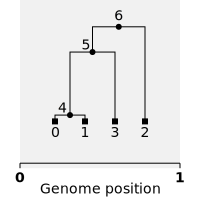

In [3]:
ts = msprime.sim_ancestry(
    samples=2, # Two diploid individuals
    random_seed=1
)
display(SVG(ts.draw_svg()))

In [4]:
ts # Note there are no mutations yet

## Specifying information about sample genomes
Although we have specified 2 samples, our tree sequence contains 4 sample nodes (i.e. sample genomes).
This is because the `samples` argument specifies the number of *individuals* in the sample,
and by default, `sim_ancestry()` assumes diploid organisms.
To change this, use the `ploidy` argument:

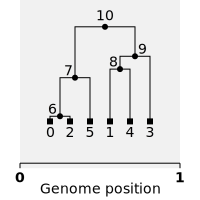

In [5]:
ts = msprime.sim_ancestry(
    samples=2,
    ploidy=3, # Two triploid individuals
    random_seed=1
)
display(SVG(ts.draw_svg()))

It's easiest to start thinking about genome lengths in units of nucleotides. By default, we are simulating a sequence length that spans just one of these units.
We can specify a larger region using the `sequence_length` argument:

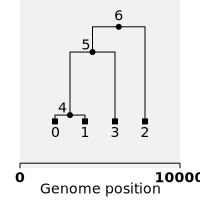

In [6]:
ts = msprime.sim_ancestry(
    samples=2,
    sequence_length=1e4, # 10 Kb
    random_seed=1
)
display(SVG(ts.draw_svg()))

Also, note that our 'tree sequence' consists of just a single tree. This is because we have not yet specified a `recombination_rate`, which is set to 0 by default. 
This is the probability of a recombination event per genomic unit (base), per generation.

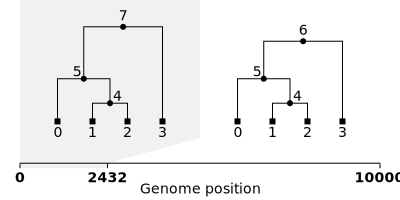

In [7]:
ts = msprime.sim_ancestry(
    samples=2,
    sequence_length=1e4,
    recombination_rate=1e-5, # Allow for recombination: this is quite a high rate
    random_seed=100
)
display(SVG(ts.draw_svg()))

## Basic population information

Finally, we need to say something about the dynamics of the wider population from which our samples have been drawn. The default is to assume a single randomly mating population of fixed size (later we will see how to change this). In a simple model like this, most users will therefore want to specify a `population_size`. Population geneticists sometimes refer to this as $N_e$, or the "effective population size" in a panmictic population.

<div class="alert alert-block alert-info"><b>Note:</b>
The standard <code>msprime</code> model is a theoretical one that allows the population size to be any floating point number greater than 0. In fact, if not specified, the population size in msprime defaults to 1, which sounds biologically impossible, but simply produces a result identical to that of a larger population with the time units scaled differently.
</div>

In [8]:
ts_small = msprime.sim_ancestry(
    samples=2,
    sequence_length=1e3, # Small 1Kb region
    recombination_rate=1e-8, # Small recombination rate
    population_size=20_000, # Rough "effective population size" suitable for humans
    random_seed=107
)
ts_small  # Display summary to screen

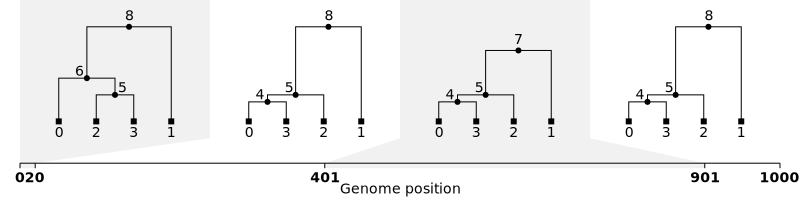

In [9]:
display(SVG(ts_small.draw_svg()))

<dl><dt>Exercise 1</dt><dd>To illustate the speed of <code>msprime</code>, simulate a large tree sequence of 20,000 diploid individuals, each with a 1 Mbp long genome, using a recombination rate of 1e-8 from a population of size 20,000. Run the simulation with a random seed of 2022,  save it to the variable `ts`, and output the summary table on the screen.
<div class="alert alert-block alert-info"><b>Tip:</b>
    Make sure you DON'T display the SVG trees! Each tree is huge, and there are a lot of them.</div></dd></dl>

In [10]:
# Exercise 1: set `ts` to a new large tree sequence, generated using msprime.sim_ancestry() with
# specific parameters (random_seed=2022, etc.), then output the tree sequence summary table to screen


In [11]:
workbook.Q1()

## Simulating mutations along the tree sequence

Next, to generate genetic variation, we add neutral mutations by applying `sim_mutations()` to the existing `TreeSequence` object. At minimum, you must supply a per-base, per-generation mutation rate.

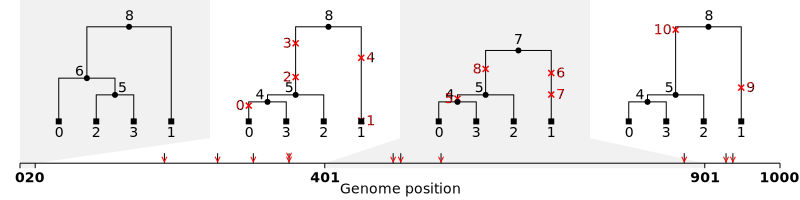

In [12]:
mts_small = msprime.sim_mutations(
    ts_small, # Use the small tree sequence so that we can plot it easily
    rate=2e-7, # Set an unusually high mutation rate per generation per base pair
    random_seed=103
)
display(SVG(mts_small.draw_svg()))

In [13]:
mts_small # Note there are 10 sites with variation but 11 mutations

<dl><dt>Exercise 2</dt><dd>Print out the mutation tables for the <code>mts_small</code> tree sequence</dd></dl>

In [14]:
# Exercise 2: print out the mutations table. Notice that one site has experienced multiple mutations.


In [15]:
workbook.Q2()

Adding mutations to a tree sequence is usually very fast, and the resulting tree sequence is a highly efficient way of storing genomic data. For instance, adding 10,000 variable sites to the large tree sequence you simulated in Exercise 1 should take less than a second, and corresponds to a storing a sites-by-samples matrix of 40,000 by 10,000 values (i.e. 400 million haploid genotypes). In tree sequence format, this only takes up about 8Mb of space. The equivalent VCF would be thousands or tens of thousands of times larger.

<dl><dt>Exercise 3</dt><dd>Add mutations to the large tree sequence generated in Exercise 1 using a mutation rate of 1e-8. Run the simulation using a random seed of 2022, and print a summary table of the resuling tree sequence to the screen</dd></dl>

In [16]:
# Exercise 3: Add lots of mutations to the huge genealogy you simulated earlier


In [17]:
workbook.Q3()

## More complicated simulations

`Msprime` allows for more realistic simulations. We have no time to cover all the additional options implemeneted in `msprime`, but they are explained in the online [API documentation](https://tskit.dev/msprime/docs/stable/intro.html). Below are some interesting and useful options:

 - **Recombination rate variation across the genome** We can introduce this by creating a `RateMap` object, which lists recombination rates between defined positions in the sequence. See this [page](https://tskit.dev/msprime/docs/stable/rate_maps.html) for more about `RateMap` objects.
```
recomb_rate_map = msprime.RateMap(position=[0, 10, 20], rate=[0.01, 0.1])
ts = msprime.sim_ancestry(3, recombination_rate=recomb_rate_map, random_seed=2)
SVG(ts.draw_svg())
```
 - **Mutation rate variation across the genome** This can also be introduced using a `RateMap` object, which lists mutation rates between defined position in the sequence. See this [page](https://tskit.dev/msprime/docs/stable/rate_maps.html) for more detail.
```
mutation_rate_map = msprime.RateMap(position=[0, 40, 60, 100], rate=[0.01, 0.1, 0.01])
mts = msprime.sim_mutations(ts, rate=mutation_rate_map, random_seed=104)
SVG(mts.draw_svg())
```
 - **Mutation models** There are [pre-defined models](https://tskit.dev/msprime/docs/stable/mutations.html) (e.g., Jukes-Cantor). You can also use your own custom models.
 - **Stacking mutations** Mutations can be simulated on the same tree sequence under different models and/or parameters and/or over different time periods.
 - **Continuous coordinates** By default, the recombination and mutation events will be assigned to integer locations along the sequence. However, there may be situations where you want to model the genome using continuous coordinates. In this case, use the `discrete_genome=False` argument:
```
ts = msprime.sim_ancestry(
    samples=2,
    random_seed=28,
    sequence_length=100,
    recombination_rate=0.01,
    discrete_genome=False
)
SVG(ts.draw_svg())
```
 - **Gene conversion** See the API documentation for the `gene_conversion_rate` and `gene_conversion_tract_length` arguments, and [this](https://tskit.dev/msprime/docs/stable/ancestry.html?highlight=gene%20conversion#gene-conversion) short illustration of use.

## Simulations under custom demographic models

To run simulations under more complicated models of demographic history, we need to create a `msprime.Demography` object.

`Msprime` can simulate multiple discrete populations, sometime called "demes". It provides a number of [built-in theoretical models](https://tskit.dev/msprime/docs/stable/demography.html#quick-reference), and a [library of community-validated demographic models](https://elifesciences.org/articles/54967) for a number of common species, including humans, is available in the [stdpopsim](https://popsim-consortium.github.io/stdpopsim-docs/stable/tutorial.html#running-stdpopsim-with-the-python-interface-api) package. Alternatively you can create your own bespoke model, or modify an existing one, by adding populations to a demography using the `.add_population()` method of the demography object (for each population, you can specify a name, a sample size, an effective population size, and a growth rate to allow population size to change over time).

Let's simulate some data using the built-in stepping stone model, specifying eight populations. First, we create the `msprime.Demography` object:

In [18]:
deme_size = 500  # Population size of each deme
num_demes = 8
num_deme_samples = 25

demography = msprime.Demography.stepping_stone_model(
    [deme_size] * num_demes,
    migration_rate=0.05
)

To visualise this, the easiest thing is to convert it to the `demes` format, which we can then draw using the rather nifty `demesdraw` package. This plots the population size (on the x-axis) against time (on the y-axis).

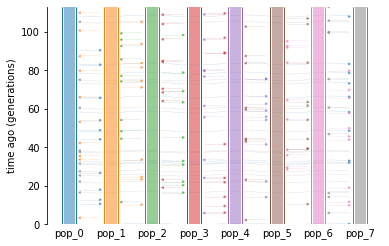

In [19]:
graph = msprime.Demography.to_demes(demography) # For visualization only

positions = {f"pop_{i}": i * deme_size * 3 for i in range(num_demes)}

fig, ax = plt.subplots() # Use plt.rcParams["figure.figsize"]
demesdraw.tubes(graph,
                ax=ax,
                positions=positions,
                seed=3)
plt.show()

Since all 8 populations are of constant size, they appear as fixed-width "tubes" through time. You can see that each has a small amount of migration (arrows) from each population to the two adjacent ones. Here's how to actually simulate this demographic setup.
<div class="alert alert-block alert-info"><b>Note:</b>
    Because of limited migration, we expect the closest relatives of an individual to be found in the same population. As for the other populations, if you look carefully at the coloured arrows, you will see that the first and last population can migrate between each other, so the populations can actually be thought of as lying on a circle. All other things being equal, from the point of view of an individual in <code>pop_0</code>, on average <code>pop_1</code> and <code>pop_7</code> should contain the next closest relatives, then <code>pop_2</code> and <code>pop_6</code>, then <code>pop_3</code> and <code>pop_5</code>; finally (being the most number of hops away) <code>pop_4</code> should contain, on average, the most distant relatives.</div>

In [20]:
mu = 1e-8 # Human-like mutation rate

ts = msprime.sim_ancestry(
    {population_id: num_deme_samples for population_id in range(num_demes)},
    sequence_length=5e6, # 5Mb
    demography=demography,
    recombination_rate=1e-8, # Human-like recombination rate
    random_seed=123,
)

mts = msprime.sim_mutations(
    ts,
    rate=mu,
    random_seed=3
)
mts  # Display it to screen: it should have 8 populations

Let's check the Fst statistics between, say, populations 0 and 1:

In [21]:
pop_0_sample_ids = mts.samples(population=0)
pop_1_sample_ids = mts.samples(population=1)

print(
    "Fst from variable sites:",
    mts.Fst([pop_0_sample_ids, pop_1_sample_ids]),
    "\nFst from genealogical branch lengths:",
    mts.Fst([pop_0_sample_ids, pop_1_sample_ids], mode="branch")
)

Fst from variable sites: 0.0036924224511847292 
Fst from genealogical branch lengths: 0.00363075557863346


<dl><dt>Exercise 4</dt><dd>Using a <code>for</code> loop, print out the standard site-based $F_{st}$ values between samples in population 0 and samples from each of the other 8 populations in turn. Does $F_{st}$ reflect the expected relationship between populations?</dd></dl>

In [22]:
# Exercise 4: Loop over the populations, printing out Fst between each and pop_0


In [23]:
workbook.Q4()

## Running the same simulation many times
Variation among simulated genetic genealogies means that there is variation in branch-wise statistics among the genealogies as well. To see this, we need a bunch of simuation replicates. The `num_replicates` argument in `sim_ancestry()` offers a convenient way to run many simulations under the same model. Here we calculate the Fst between two adjacent populations in our stepping stone model:

In [24]:
Fst_vals = []

for ts in msprime.sim_ancestry(
    {i: num_deme_samples for i in range(num_demes)},
    sequence_length=2e6,
    demography=demography,
    recombination_rate=1e-8,
    random_seed=1234,
    num_replicates=100
):
    Fst = ts.Fst([ts.samples(0), ts.samples(1)], mode="branch")
    Fst_vals.append(float(Fst))  # for convenience, convert the numpy array returned by ts.Fst to a standard number

<dl><dt>Exercise 5</dt><dd>Use <code>plt.hist()</code> to plot the histogram of Fst values between populations 0 and 1, and <code>np.mean()</code> to print out the mean. How much do stochastic events in genealogical history contribute to variation in measures of population differentiation?</dd></dl>

In [25]:
# Exercise 5: plot a histogram of Fst values: 


In [26]:
workbook.Q5()

## More complicated demographic models

`Msprime` can simulate data under more complicated demographic models, which are beyond the scope of this workshop. Some demographic events and features that can be introduced into custom models include:

 - Varying population size.
 - Population structure (multiple demes with different migration rates).
 - Migration (constant or varying migration rates).
 - Admixture.
 - Population divergence.

# Inference using `tsinfer` and `tsdate`

Simulating genetic genealogies is relatively simple compared to inferring them from existing genetic data. Several software packages infer genetic genealogies which can be stored in tree sequence format, but by far the most scalable ones are [tsinfer](https://github.com/tskit-dev/tsinfer) and [tsdate](https://github.com/tskit-dev/tsdate).

### A note about models vs reality

So far we have been using rather simplified models of population history. While slightly more realistic models [are available](https://elifesciences.org/articles/54967), it is still true that "All models are wrong, but some models are useful". In fact, when trying to infer the real history of interbreeding populations, the complexity of hybridization, migration, and sexual behaviour probably justifies something more emphatic: "all models are wrong, but population history models are especially wrong".

It is common to want to use genetic variation to establish or demolish support for particular models of population history, perhaps attempting to estimate parameters such as a migration rate. However, any cursory inspection of (say) human history should convince you that we shouldn't place much faith in a model of discrete populations with a handful of estimated parameters.

In this vein, when using the genealogical inference approaches below to look at real datasets, you are encouraged not to approach the analysis with a predefined model in your head. Rather you should use the results as an tool to explore the dominant patterns that emerge from the data. In particular, the `tsinfer` algorithm has relatively few underlying assumptions (e.g. it does not assume neutrality, fixed population sizes, or specific timings of ancestral events). That means it can be used to examine the data in a relatively model-free way.

Of course, if you are only interested in using tsinfer to compress your genome sequences, and don't care about how they came about, then this point is moot!

## Inferring topology using `tsinfer`

`Tsinfer` (pronounced t-s-infer) is comparable in some ways to other ancestral inference software such as [ARGweaver](https://doi.org/10.1371/journal.pgen.1004342), [Relate](https://myersgroup.github.io/relate/) (which we will encounter this afternoon), and [Rent+](https://doi.org/10.1093/bioinformatics/btw735). However, it differs considerably in approach and scalability. Note that none of these other software packages produce their output in tree sequence (`tskit`) format, although is possible to convert their output to tree sequences. Also note that although `tsinfer` produces trees with a relatively accurate topology, but unlike other ancestral inference tools, it makes no attempt to produce branch length estimates -- for this we need another tool like `tsdate`.

The most important restrictions of `tsinfer` are:
1. It requires *phased* sample sequences
2. It only uses variants which have *known ancestral states* (other variants can be included, but do not contribute to the quality of inference)
3. It works better with full sequence data than with data from scattered target SNPs (e.g. as obtained from SNP chips).

Inferences of large datasets (whole genomes from tens of thousands or samples or more) can take many days of computer time. For this reason, we will use a relatively small dataset: the genetic data that we simulated above using `msprime`. This comprises 2Mb of genome (roughly 2500 sites) from 360 individuals (720 diploid genomes). A benefit of using a simulated dataset is that we can estimate how good out inference is.

Even though it is a small dataset, it would take hours or days to run using many other inference packages. `Tsinfer` should be able to do this in a few seconds.

### Input

`Tsinfer` requires a [SampleData](https://tsinfer.readthedocs.io/en/latest/api.html#sample-data) object as input. There are <a href="https://tsinfer.readthedocs.io/en/latest/tutorial.html#data-example">examples online</a> for how to create a SampleData file from the common VCF format. To save time in this workbook, instead of going via VCF files, we will use a built-in shortcut that creates a `SampleData` instance directly from an existing mutation-containing tree sequence. 

In [27]:
sample_data = tsinfer.SampleData.from_tree_sequence(mts)  # Normally you would probably create this from a VCF file

Now that we have the genetic variation data in `SampleData` format (as phased haplotypes with known ancestral states), we can actually perform the inference.

The inference process is split into three independent steps (`generate_ancestors`, `match_ancestors` and `match_samples`), but for small datasets there is a convenience function, `tsinfer.infer()` which runs all three steps at once. Inferring a tree sequence is thus as simple as calling this function:

<div class="alert alert-block alert-info"><b>Note:</b>
    For larger inferences, we recommend running <code>tsinfer</code> from the command-line rather than within the Python shell. To speed up inference, it is also possible to run it on a large number of computer processors in parallel.</div>

In [31]:
# This may take a few tens of seconds
inferred_ts = tsinfer.infer(sample_data)
inferred_ts  # Display on screen

From the 5413 variable sites in a simulated tree sequence of 4009 nodes and 18218 edges (1.1 MiB)
 we have inferred a new tree sequence of 3665 nodes and 10575 edges (1.0 MiB)


And that's it! As you can see, the output is a `TreeSequence` object of the sort we have previously met, and which should be very efficient to process. In fact, this tree sequence is even slightly *smaller* than the simulated one. 

However, the inferred tree sequence is not a perfect reconstruction of the true (simulated) genealogy. If we print out the first tree, colouring sample nodes by their population, it reveals a few properties that are not seen in the original genealogy:

In [ ]:
# Create a style that colours nodes by their population, matching the demesdraw output
colour_map = plt.get_cmap("tab10")
hex_cols = [mpl.colors.rgb2hex(colour_map(p.id)) for p in inferred_ts.populations()]
plot_style = "".join([f".node.p{p.id} > .sym {{fill: {hex_cols[p.id]}}}" for p in inferred_ts.populations()])

svg_text = inferred_ts.first().draw_svg(
    size=(1500, 400),  # Wider than the normal screen, to fit in all the samples
    node_labels={},
    y_axis=True,
    y_ticks=np.arange(0, 1, 0.1),
    symbol_size=3,
    style=plot_style,
)

display(SVG(svg_text))

What you might notice:
1. There are *polytomies* in the tree sequence (nodes with more than two descending branches), reflecting uncertainty in the tree
2. There are *unary nodes* in the tree (nodes with only one descending branch, appearing as points on straight branches). For technical reasons these can help to compress the data
3. The time scale runs from 0 to 1 rather than showing the number of generations

The last two points will be covered later, when we introduce `tsdate`.

### Is  the inference any good?

If you are using the inferred ts simply to calculate site-wise statistics, then it doesn't matter whether your inference is accurate:

<dl><dt>Exercise 6</dt>
<dd>Use the <code>.diversity()</code> method to print out the site-based genetic diversity of all your samples, both from the original tree sequence (<code>mts</code>) and the inferred one (<code>inferred_ts</code>). They should be the same.
<div class="alert alert-block alert-info"><b>Note:</b>
You will not be able to run the branch length versions of the statistics on the inferred tree sequence, because although `tsinfer` provides a reasonable estimate of the *topology* of the tree sequence, but does not provide meaningful branch lengths. For that we need to *date* the tree sequence nodes. 
</div></dd></dl>

In [ ]:
# Exercise 6: print out the site-based genetic diversity of the original and inferred tree sequences 


In [53]:
workbook.Q6()

AttributeError: 'Workbook2' object has no attribute 'Q6'

However, there's a good chance that you want to treat the inferred genealogy as an noisy estimate of the true genealogy. In this case we want some way to measure if our inference was any good. We will encounter one way to quantify this once we have meaningful branch lengths on the genealogy, further below. Since we don't have meaningful branch lengths yet, however, we can't use measures that depend on that property of the trees. Instead, we will look at a purely topological measure, the *genealogical nearest neighbour* statistic.

<div class="alert alert-block alert-info"><b>Note:</b>
A more quantitative method that can be run on the undated inferred tree sequence is to compare the topology of the real versus the inferred trees as we go along the genome. This can be done in <code>tskit</code> using the <a href="https://tskit.dev/tskit/docs/stable/python-api.html#tskit.TreeSequence.kc_distance">Kendall-Colijn tree distance metric</a>. However, it is not clear what values of this statistic should be compared against, especially when a tree has polytomies, so we will not cover it in this practical.
</div>

#### The genealogical nearest neighbour (GNN) metric

<img src="pics/GNN.png" style="float:left" width="250" height="250"> The GNN summarises features of the tree topologies. It requires us to split the samples into groups (here, the 8 simulated populations), and for each sample in turn (the "focal sample"), looks at the nearest neighbours in each local tree.

In the example to the left, we take the leftmost (red) node as the focal sample. Its nearest neighbours can be found by following the arrow up then down again. So the GNN proportions of the leftmost node are 50% red, 25% yellow, and 25% blue (i.e. `0.5 : 0.25 : 0.25`)

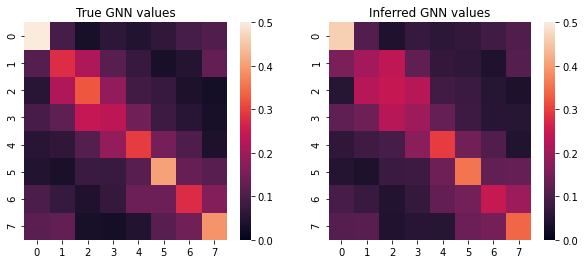

In [52]:
# Compare the average GNN proportions from the true and inferred genealogies
gnn_vals = {}
for name, ts in [("true", mts), ("inferred", inferred_ts)]:
    gnn_vals[name] = np.array([
        np.mean( # take an average over all the samples in a population
            ts.genealogical_nearest_neighbours(
                ts.samples(i),
                [ts.samples(j) for j in range(num_demes)]
            ),
            axis=0,
        )
        for i in range(num_demes)
    ])

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4)) # Use plt.rcParams["figure.figsize"]
ax1.set_title("True GNN values")
sns.heatmap(gnn_vals["true"], vmin=0, vmax=0.5, ax=ax1)
ax2.set_title("Inferred GNN values")
sns.heatmap(gnn_vals["inferred"], vmin=0, vmax=0.5, ax=ax2)
plt.show()

You can see that the inference does extremely well at capturing the genealogical relationships. The diagonal shows that the closest relatives are indeed found in the same population, and the proportions of close relatives decrease as we move to successivly more distant populations. We should have some confidence that the inference has worked.

The site-wise statistics of the two tree sequences are identical, simply because the sites stored in the tree sequences are identical. However, the branch-wise statistics of the tree sequences differ noticeably. To put biologically meaningful branch lengths onto the inferred tree sequence, we need to use `tsdate`.

## Estimating tree sequence node times using tsdate

Before we can date the inferred tree sequence, we must first preprocess it using `preprocess_ts()`. This method simplifies the tree sequence (so it does not contain "unary nodes", which are problematic to date) and removes long regions of no data, which can bias the results.

In [ ]:
# This may take a few tens of seconds
dated_ts = tsdate.date(
    tsdate.preprocess_ts(inferred_ts),
    mutation_rate=mu,
    Ne=2000, # rough equivalent total effective population size in the stepping-stone model
    ignore_oldest_root=True
)

Now when we plot out the tree sequence, it should have a more sensible time-scale:

In [ ]:
subset_sample_ids = np.concatenate(
    [dated_ts.samples(p.id)[:4] for p in dated_ts.populations()] # Get four nodes from each population
)

simple_dated_ts = dated_ts.simplify(samples=subset_sample_ids)

svg = simple_dated_ts.draw_svg(
    x_lim=[10_000, 30_000],
    size=(1000, 400),
    node_labels={},
    mutation_labels={},
    y_axis=True,
    y_ticks=np.arange(0, 20000, 5000),
    symbol_size=3,
    style=plot_style
)

display(SVG(svg))

We can estimate how well the dating has done (which is also a reasonable test of the `tsinfer` step), by comparing times in the simulated tree sequence with times in the inferred tree sequence. However, unless the tree topologies are identical, the simulated and inferred tree sequences will not have directly comparable nodes. We could either exhaustively compare the time of every MRCA pairwise, or we could compare the node times below each mutation. Here's how to do the latter:

In [ ]:
data = {"simulated": {}, "inferred": {}}
for ts, data_name in [[mts, "simulated"], [dated_ts, "inferred"]]:
    node_below_mutation_at_position = data[data_name]
    for s in ts.sites():
        if len(s.mutations) == 1:
            # Only save information for sites with a single mutation
            mutation_id = s.mutations[0].id
            node_id = ts.mutation(mutation_id).node
            node_time = ts.node(node_id).time
            if node_time > 0:
                # Only plot shared nodes
                node_below_mutation_at_position[s.position] = node_time

shared_positions = set(data["simulated"].keys()) & set(data["inferred"].keys())
true_node_times = np.array([data["simulated"][pos] for pos in shared_positions])
inferred_node_times = np.array([data["inferred"][pos] for pos in shared_positions])

# What's the R^2 value?
cor_coef = np.corrcoef(np.log(true_node_times), np.log(inferred_node_times))
print("R squared of log times:", cor_coef[0,1]**2)

<dl><dt>Exercise 6</dt>
<dd><p>Use <code>plt.scatter(true_node_times, inferred_node_times, alpha=0.05)</code> to plot the inferred node times against the true node times, setting some alpha transparency on the plotted points.</p>

<p>Since variablility in time estimates is much greater for larger times, you should plot both X and Y on a log axis, using <code>plt.xscale('log')</code> and <code>plt.yscale('log')</code>. You can also label the axes using <code>plt.xlabel()</code> and <code>plt.ylabel()</code>, and add an $x=y$ line by <code>plt.plot([1, 1e4], [1, 1e4], "k-")</code>. How well did the dating work?</p></dd></dl>

In [ ]:
# Exercise 6: plot true node times against inferred node times below the mutation at each site.


### Branch-wise statistics

Let's calculate and compare some site-wise and branch-wise statistics (Fst and divergence) from the simulated tree sequence and the dated tree sequence. We can see that the site-wise Fst statistics of the two tree sequences are identical, but the branch-wise Fst statistics are different because the branch lengths of the dated tree sequence were estimated.

In [ ]:
Fst_true_ts = mts.Fst([mts.samples(0), mts.samples(4)])
Fst_dated_ts = dated_ts.Fst([dated_ts.samples(0), dated_ts.samples(4)])

print(
    "Site-wise calculations:",
    f"Fst (true     ts) = {Fst_true_ts}",
    f"Fst (dated    ts) = {Fst_dated_ts}",
    sep="\n",
)

In [ ]:
Fst_branch_true_ts = mts.Fst([mts.samples(0), mts.samples(4)], mode="branch")
Fst_branch_dated_ts = dated_ts.Fst([dated_ts.samples(0), dated_ts.samples(4)], mode="branch")

print(
    "Branch-wise calculations:",
    f"Fst (true     ts) = {Fst_branch_true_ts}",
    f"Fst (dated    ts) = {Fst_branch_dated_ts}",
    sep="\n",
)

Similarly, site-wise divergence statistics should be identical, whereas branch-wise divergence statistics should be different.

In [ ]:
div_true_ts = mts.divergence([mts.samples(0), mts.samples(5)])
div_dated_ts = dated_ts.divergence([dated_ts.samples(0), dated_ts.samples(5)])

print(
    "Site-wise calculations:",
    f"divergence (true  ts) = {div_true_ts}",
    f"divergence (dated ts) = {div_dated_ts}",
    sep="\n",
)

In [ ]:
div_branch_true_ts = mts.divergence([mts.samples(0), mts.samples(5)], mode="branch")
div_branch_dated_ts = dated_ts.divergence([dated_ts.samples(0), dated_ts.samples(5)], mode="branch")

print(
    "Branch-wise calculations:",
    f"divergence (true  ts) = {div_branch_true_ts}",
    f"divergence (dated ts) = {div_branch_dated_ts}",
    sep="\n",
)

We can use GNN even on *undated* tree sequences, because it does not depend on branch lengths. This is unlike e.g. Fst or diversity measures.

In [ ]:
gnn_heatmap = np.array([
    np.mean(
        mts.genealogical_nearest_neighbours(
            mts.samples(i),
            [mts.samples(j) for j in range(num_demes)]
        ),
        axis=0,
    )
    for i in range(num_demes)
])

sns.clustermap(gnn_heatmap, row_cluster=False, col_cluster=False);

In [ ]:

sns.clustermap(gnn_heatmap, row_cluster=False, col_cluster=False);

*** To work up ***: The dendrogram to the side, if plotted, can be misleading, e.g. in this case it isn't a tree because the populations are on a torus.

## Some relevant papers and resources
 -  [Efficient coalescent simulation and genealogical analysis for large sample sizes](https://doi.org/10.1371/journal.pcbi.1004842)
 - [Efficient ancestry and mutation simulation with msprime 1.0](https://doi.org/10.1093/genetics/iyab229)
 - [tskit.dev documentation](https://tskit.dev/)

## Acknowledgement
This workbook is heavily based on [Georgia Tsambos' Jupyter notebooks](https://github.com/gtsambos/2022-ts-workshops).